<a href="https://colab.research.google.com/github/flowergum/Colorization/blob/main/My_colorization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, \
                                    Dense, \
                                    MaxPool2D,\
                                    Dropout, \
                                    Flatten, \
                                    BatchNormalization, InputLayer, UpSampling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from skimage.color import rgb2lab, lab2rgb
import tensorflow as tf
from skimage.io import imsave
import numpy as np
from google.colab import files
from io import BytesIO
from PIL import Image
import matplotlib.pyplot as plt

In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [ ]:
def processed_image(img):
  image = img.resize( (128, 128))               # нужный нам размер
  image = np.array(image, dtype=float)          # в массив
  size = image.shape                            # размер изображения
  lab = rgb2lab(1.0/255*image)                  #  в лаб, предварительно переведя в диапазон от 0 до 1
  X, Y = lab[:,:,0], lab[:,:,1:]                #в Х кладем яркостную компоненту, в Y -- две цветовые

  Y /= 128                                     # нормируем выходные значение в диапазон от -1 до 1
  X = X.reshape(size[0], size[1], 1)
  Y = Y.reshape(size[0], size[1], 2)
  return X, Y, size

In [ ]:
#Dataset
import glob
from PIL import Image 

x_train = []
y_train = []

i = 0
for f in glob.iglob("drive/MyDrive/Colorization/2_Natural_Images/data/natural_images/dog/*"):
    X, Y, size = processed_image(Image.open(f))
    x_train.append(np.asarray(X))
    y_train.append(np.asarray(Y))
    i = i+1
    if i == 500:
        break

i = 0
for f in glob.iglob("drive/MyDrive/Colorization/2_Natural_Images/data/natural_images/car/*"):
    X, Y, size = processed_image(Image.open(f))
    x_train.append(np.asarray(X))
    y_train.append(np.asarray(Y))
    i = i+1
    if i == 500:
        break

i = 0
for f in glob.iglob("drive/MyDrive/Colorization/2_Natural_Images/data/natural_images/cat/*"):
    X, Y, size = processed_image(Image.open(f))
    x_train.append(np.asarray(X))
    y_train.append(np.asarray(Y))
    i = i+1
    if i == 500:
        break



# i = 0
# for f in glob.iglob("drive/MyDrive/Colorization/Step_2.Flowers/input/flowers/flowers/tulip/*"):
#     X, Y, size = processed_image(Image.open(f))
#     x_train.append(np.asarray(X))
#     y_train.append(np.asarray(Y))
#     i = i+1
#     if i == 500:
#         break

x_train = np.array(x_train)
y_train = np.array(y_train)

print(x_train.shape, y_train.shape)

(1500, 128, 128, 1) (1500, 128, 128, 2)


(1500, 128, 128, 3)


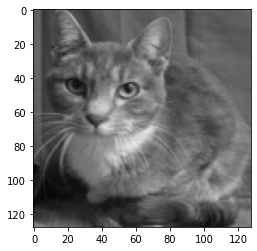

In [ ]:
images = np.concatenate((x_train, y_train), axis = 3)
print(images.shape)
#plt.imshow(lab2rgb(images[1]))
np.random.shuffle(images)
plt.imshow(lab2rgb(images[1]))
x_train, y_train = np.reshape((images[:, :, :, 0]), (images.shape[0], images.shape[1], images.shape[2], 1)), np.reshape((images[:, :, :, 1:]), (images.shape[0], images.shape[1], images.shape[2], 2))
#print(x_train.shape, y_train.shape)


In [ ]:
# img = Image.open('drive/MyDrive/Colorization/Step_2.Flowers/test/6.jpg')   # тут проверяем, что пространство норм 
# image = img.resize( (128, 128))              
# image = np.array(image, dtype=float)         
# size = image.shape                           
# lab = rgb2lab(1.0/255*image)                 
# X, Y, Z = lab[:,:,0], lab[:,:,1], lab[:,:,2] 
# A = np.zeros((128, 128))                                 
# #X = X.reshape(1, size[0], size[1], 1)
# #Y = Y.reshape(1, size[0], size[1], 1)
# #Z = Z.reshape(1, size[0], size[1], 1)
# print(X.shape, ', ', Y.shape, ', ', Z.shape)
# X1 = np.stack((X, A, A), axis=2)
# Y1 = np.stack((A, Y, A), axis=2)
# Z1 = np.stack((A, A, Z), axis=2)
# A1 = np.stack((X, Y, Z), axis=2)
# print(X1.shape)
# plt.subplot(2, 4, 1)
# plt.imshow(lab2rgb(X1))
# plt.subplot(2, 4, 2)
# plt.imshow(lab2rgb(Y1))
# plt.subplot(2, 4, 3)
# plt.imshow(lab2rgb(Z1))
# plt.subplot(2, 4, 4)
# plt.imshow(lab2rgb(A1))
# #Как я поняла, дальше он сам решает, что ему дали только зеленый канал или только красный, оэтому получаются странные результаты
# plt.subplot(2, 4, 5)
# plt.imshow((X1))
# plt.subplot(2, 4, 6)
# plt.imshow((Y1))
# plt.subplot(2, 4, 7)
# plt.imshow((Z1))
# plt.subplot(2, 4, 8)
# plt.imshow((A1))

In [ ]:
model = Sequential()                                                      # Последовательная
model.add(InputLayer(input_shape=(None, None, 1)))                        # Входной слой, подаем на вход яркостную компоненту
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))          # Свертка, 64 фильтра
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
#model.add(UpSampling2D((2, 2))) #Растягивает картинку
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
#model.add(UpSampling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(2, (3, 3), activation='tanh', padding='same'))
model.add(UpSampling2D((2, 2)))

In [ ]:
model2 = Sequential()     #из статьи сравниваю
model2.add(InputLayer(input_shape=(None, None, 1)))
model2.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model2.add(Conv2D(64, (3, 3), activation='relu', padding='same', strides=2))
model2.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model2.add(Conv2D(128, (3, 3), activation='relu', padding='same', strides=2))
model2.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model2.add(Conv2D(256, (3, 3), activation='relu', padding='same', strides=2))
model2.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model2.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model2.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model2.add(UpSampling2D((2, 2)))
model2.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model2.add(UpSampling2D((2, 2)))
model2.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model2.add(Conv2D(2, (3, 3), activation='tanh', padding='same'))
model2.add(UpSampling2D((2, 2)))

model2.compile(optimizer='adam', loss='mse')

In [ ]:
model2.fit(x=x_train, y=y_train, batch_size=100, epochs=35) #всего 55 эпох (55 -- оптимально: размер изображения: 128*128, 2500 картинок на 5 классов)

Epoch 1/35
25/25 [==============================] - 7s 282ms/step - loss: 0.0279
Epoch 2/35
11/25 [============>.................] - ETA: 3s - loss: 0.0288

KeyboardInterrupt: ignored

In [ ]:
model.compile(optimizer='adam', loss='mse')

In [ ]:
model.load_weights("drive/MyDrive/Colorization/weights/st_1_flowers.h5")

In [ ]:
model.fit(x=x_train, y=y_train, batch_size=100, epochs=55)

Epoch 1/55
15/15 [==============================] - 15s 360ms/step - loss: 0.0119
Epoch 2/55
15/15 [==============================] - 5s 359ms/step - loss: 0.0082
Epoch 3/55
15/15 [==============================] - 5s 359ms/step - loss: 0.0075
Epoch 4/55
15/15 [==============================] - 5s 358ms/step - loss: 0.0075
Epoch 5/55
15/15 [==============================] - 5s 359ms/step - loss: 0.0074
Epoch 6/55
15/15 [==============================] - 5s 358ms/step - loss: 0.0070
Epoch 7/55
15/15 [==============================] - 5s 358ms/step - loss: 0.0077
Epoch 8/55
15/15 [==============================] - 5s 358ms/step - loss: 0.0074
Epoch 9/55
15/15 [==============================] - 5s 358ms/step - loss: 0.0074
Epoch 10/55
15/15 [==============================] - 5s 358ms/step - loss: 0.0074
Epoch 11/55
15/15 [==============================] - 5s 356ms/step - loss: 0.0072
Epoch 12/55
15/15 [==============================] - 5s 356ms/step - loss: 0.0071
Epoch 13/55
15/15 [=====

(1, 128, 128, 1)


/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 34 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


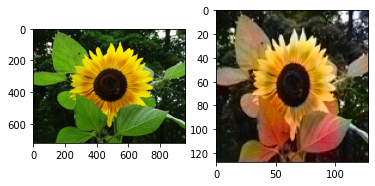

In [ ]:
img = Image.open('drive/MyDrive/Colorization/1_Flowers/input/flowers/flowers/sun-flower-2593596_960_720.jpg')
#Если захотим посмотреть на кота: "drive/MyDrive/Colorization/2_Natural_Images/data/natural_images/cat/cat_0873.jpg"
#Цветок: "drive/MyDrive/Colorization/1_Flowers/input/flowers/flowers/sun-flower-2593596_960_720.jpg"
A, Y, size = processed_image(img)
X = np.reshape((A), (1, 128, 128, 1))
print(X.shape)
output = model.predict(X)


output *= 128
min_vals, max_vals = -128, 127
ab = np.clip(output[0], min_vals, max_vals)

cur = np.zeros((size[0], size[1], 3))
cur[:,:,0] = np.clip(X[0][:,:,0], 0, 100)
cur[:,:,1:] = ab
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.subplot(1, 2, 2)
plt.imshow(lab2rgb(cur))



In [ ]:
model.save_weights("drive/MyDrive/Colorization/weights/st_2_car_dog_cat.h5")

In [ ]:
# model = Sequential()                                                      # Последовательная
# model.add(InputLayer(input_shape=(None, None, 1)))                        # Входной слой, подаем на вход яркостную компоненту
# model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))          # Свертка, 64 фильтра
# model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
# model.add(MaxPool2D(pool_size=(2, 2)))
# model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
# model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
# model.add(MaxPool2D(pool_size=(2, 2)))
# model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
# model.add(UpSampling2D((2, 2))) #Растягивает картинку
# model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
# model.add(UpSampling2D((2, 2)))
# model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
# model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
# model.add(Conv2D(2, (3, 3), activation='tanh', padding='same'))